In [12]:
# Studying a piece of land and analyzing the geography for use with irrigation

# Add the Python ArcGIS package to the default Anaconda packages that were installed during Navigator install
!pip install arcgis

In [ ]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

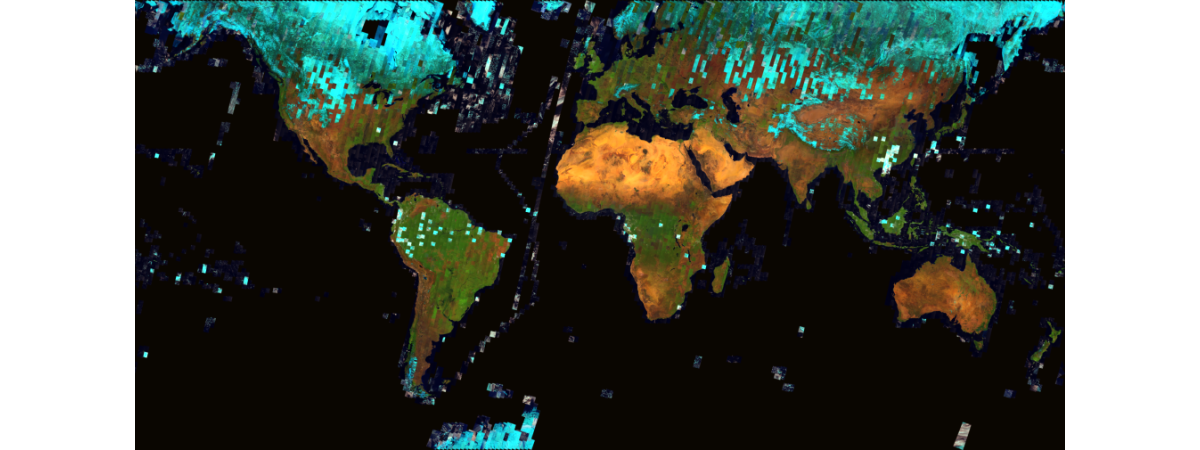

In [13]:
gis = GIS()

arcgis.raster.analytics.is_supported(gis)

search_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = search_item.layers[0]

landsat

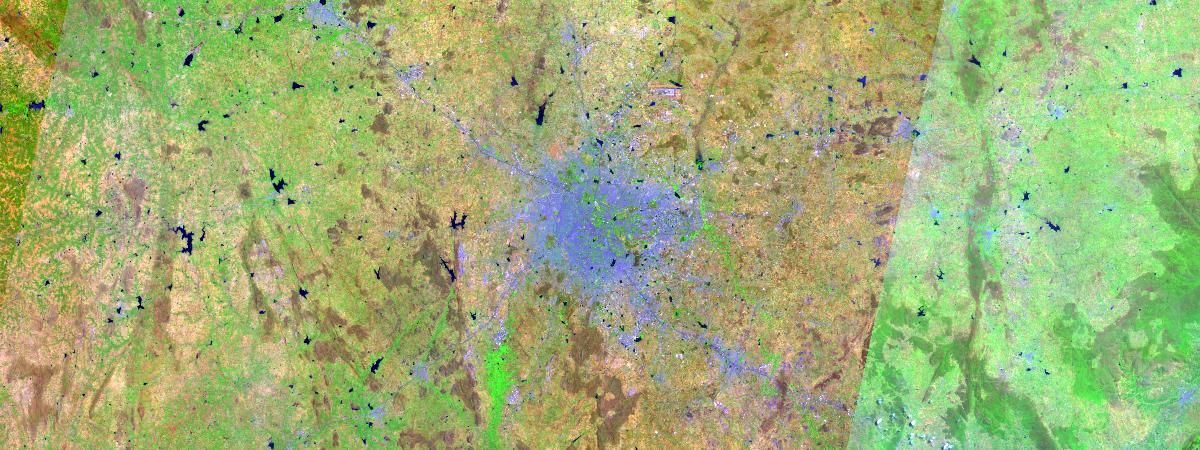

In [14]:
# Access ArcGIS online tools to get a satellite image of the Bangalore region

from arcgis.geocoding import geocode

extent = geocode("Bangalore, India", out_sr=landsat.properties.spatialReference)[1]
landsat.extent = extent['extent']
landsat

In [29]:
# Use the GMRT online mapping tool to get terrain for an area east of Bangalore
# https://www.gmrt.org/GMRTMapTool/

# Bangalore is centered at: [12.971599, 77.594566]
# So use bounds of [12.99, 77.59] and [13.01, 77.57]

# Save the terrain grid as ArcASCII File Format, and High Grid Resolution
# It downloads an .asc file with 39 columns and 35 rows

# Read in the terrain to a two-dimensional array:

import numpy as np

Terrain  = np.loadtxt("GMRTv4_2_1_20240604topo.asc", skiprows=6)
print(Terrain[1][12])

-114.85


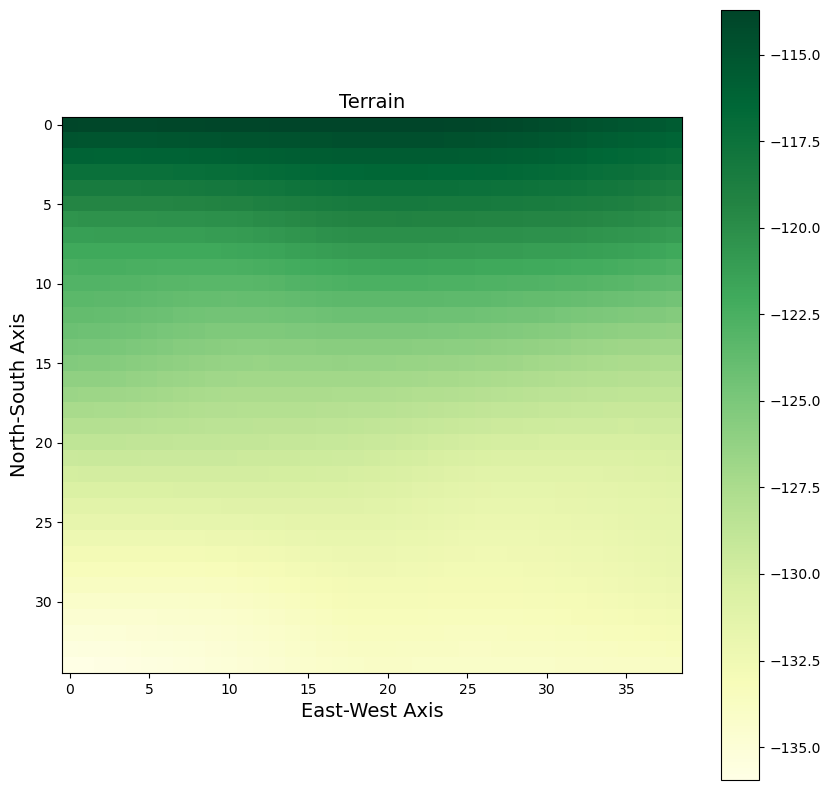

In [37]:
#Plot the terrain to see it visually

import matplotlib.pyplot as plt
from PIL import Image  #images processing package

def plot_terrain():
    #plot forest cover
    plt.figure(figsize=(10, 10))
    plt.imshow(Terrain)

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('Terrain', fontsize=14);
    plt.set_cmap("YlGn")
    plt.colorbar()
    
    plt.show()
        
plot_terrain()

In [55]:
# Set a uniform soil depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Soil = np.zeros([ny, nx], dtype = float)

def fill_soil_grid():
    #fill the Soil grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Soil[j][i] = 2

fill_soil_grid()

print (Soil)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [62]:
# Set a uniform water table depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Winit = np.zeros([ny, nx], dtype = float)

def fill_water_table_grid():
    #fill the Water grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Winit[j][i] = 1

fill_water_table_grid()

print (Winit)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [83]:
# Set a uniform soil depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Forest = np.zeros([ny, nx], dtype = float)

def fill_forest_grid():
    #fill the Soil grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Forest[j][i] = 50

fill_soil_grid()

print (Forest)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [104]:
#Calculate the water surface flow

import numpy as np

def calculate_flow(dem):
    rows, cols = dem.shape
    flow_direction = np.zeros((rows, cols), dtype=int)
    flow_slope = np.zeros((rows, cols), dtype=float)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            max_slope = 0
            direction = 0
            current_elevation = dem[i, j]
            for di, dj, d in [(-1, 0, 1), (1, 0, 1), (0, -1, 1), (0, 1, 1), (-1, -1, np.sqrt(2)), (-1, 1, np.sqrt(2)), (1, -1, np.sqrt(2)), (1, 1, np.sqrt(2))]:
                neighbor_elevation = dem[i + di, j + dj]
                slope = (current_elevation - neighbor_elevation) / d
                if slope > max_slope:
                    max_slope = slope
                    direction = (di + 1) * 3 + (dj + 1)
            flow_direction[i, j] = direction
            flow_slope[i, j] = max_slope
    return [flow_direction, flow_slope]

# Example DEM
dem = Terrain

result = calculate_flow(dem)
flow_direction = result[0]
slope = result[1]

In [105]:
# Run a hydrology model that drives water movement

import numpy as np     #numeric processing package
import math as math    #mathematics functions package
import random

river_flow = 2.855e10 # cm^3/second  #flow of river at start

#Define the Parameters (lengths all in cm)
L=390000;  # length of estuary in cm (3.9 kilometers) East-West Distance
h=350000;  # width of estuary in cm (3.5 kilometers)  North-South Distance
dx=10000;  # E-W grid spacing in cm (100 meters) East-West Spacing
dy=10000;  # N-S grid spacing in cm (100 meters) North-South Spacing

#Factors controlling water diffusion
Kh=2.895e-5; # TO RESEARCH: horizontal diffusivity (2.895 x 10^-5 cm^2/s)
Kv=2.895e-5; # TO RESEARCH: vertical diffusivity   (2.895 x 10^-5 cm^2/s)

ntimes=7*24+1; # number of time steps (seven days)
dt=3600;       # time per time step (one hour)

Precip = [ #total precipitation for 35 (length) x 39 (width) 2-D array
    [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213],
    [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213],
    [0.1935,1.08,2.9676,2.856,2.7453,2.6353,2.5261,2.4175,2.3097,2.2027,2.0963,2.9906,2.8856,2.7811,2.6772,2.5738,2.4707,2.3681,2.2657,2.1637,2.0618,2.9601,2.8585,2.757,2.6557,2.5544,2.4531,2.3519,2.2507,2.1495,2.0483,3.9471,3.846,3.7448,3.6437,3.5425,3.4414,3.3403,3.2391],
    [0.2581,1.1368,1.0178,2.9009,2.7858,2.6724,2.5605,2.45,2.3407,2.2327,2.1257,2.0196,2.9144,2.81,2.7062,2.603,2.5003,2.398,2.296,2.1944,2.0929,2.9916,2.8905,2.7895,2.6886,2.5877,2.4869,2.3861,2.2854,2.1846,2.0839,3.9832,3.8825,3.7818,3.6811,3.5804,3.4797,3.379,3.2783],
    [0.3226,1.1966,1.0736,2.9534,2.8356,2.7201,2.6066,2.4949,2.3849,2.2764,2.1692,2.0632,2.9582,2.8541,2.7507,2.648,2.5458,2.4441,2.3427,2.2417,2.1408,2.0402,2.9398,2.8394,2.7391,2.6389,2.5388,2.4387,2.3386,2.2385,2.1385,2.0384,3.9384,3.8383,3.7383,3.6383,3.5382,3.4382,3.3382],
    [0.3871,1.2584,1.1332,1.0112,2.8921,2.7756,2.6615,2.5496,2.4395,2.3311,2.2243,2.1187,2.0142,2.9107,2.8081,2.7061,2.6047,2.5038,2.4033,2.3031,2.2031,2.1034,2.0038,2.9043,2.8049,2.7056,2.6063,2.5071,2.4078,2.3086,2.2094,2.1103,2.0111,3.9119,3.8127,3.7136,3.6144,3.5152,3.4161],
    [0.4516,1.3216,1.1956,1.073,2.9537,2.8372,2.7234,2.6118,2.5023,2.3946,2.2885,2.1837,2.0802,2.9776,2.876,2.775,2.6747,2.5749,2.4754,2.3763,2.2774,2.1787,2.0802,2.9818,2.8834,2.7852,2.687,2.5888,2.4906,2.3925,2.2944,2.1963,2.0982,2.0001,3.902,3.8039,3.7058,3.6077,3.5096],
    [0.5161,1.3862,1.2604,1.1383,1.0196,2.9039,2.7909,2.6803,2.5719,2.4653,2.3603,2.2568,2.1545,2.0532,2.9528,2.8531,2.7541,2.6555,2.5573,2.4595,2.3619,2.2645,2.1672,2.0701,2.973,2.876,2.7791,2.6822,2.5853,2.4885,2.3916,2.2948,2.1979,2.1011,2.0043,3.9075,3.8106,3.7138,3.617],
    [0.5806,1.452,1.3275,1.2068,1.0895,2.9752,2.8637,2.7545,2.6476,2.5425,2.439,2.337,2.2362,2.1364,2.0375,2.9394,2.8418,2.7447,2.648,2.5517,2.4556,2.3597,2.2639,2.1683,2.0727,2.9772,2.8817,2.7863,2.6909,2.5955,2.5002,2.4048,2.3094,2.2141,2.1187,2.0234,3.928,3.8327,3.7373],
    [0.6452,1.5189,1.3966,1.2781,1.1629,1.0507,2.9411,2.8339,2.7289,2.6256,2.524,2.4238,2.3248,2.2267,2.1296,2.0332,2.9373,2.842,2.747,2.6523,2.5579,2.4637,2.3696,2.2757,2.1818,2.088,2.9942,2.9005,2.8068,2.7131,2.6194,2.5257,2.432,2.3384,2.2447,2.1511,2.0574,3.9637,3.8701],
    [0.7097,1.5868,1.4677,1.3521,1.2397,1.1301,1.023,2.9182,2.8154,2.7144,2.6149,2.5167,2.4197,2.3237,2.2285,2.1341,2.0402,2.9467,2.8537,2.7609,2.6684,2.5761,2.4839,2.3918,2.2998,2.2079,2.116,2.0242,2.9323,2.8405,2.7487,2.6569,2.5651,2.4734,2.3816,2.2898,2.198,2.1062,2.0145],
    [0.7742,1.6556,1.5405,1.4286,1.3195,1.2131,1.1089,1.0069,2.9067,2.8082,2.7111,2.6153,2.5206,2.4268,2.3338,2.2415,2.1497,2.0584,2.9674,2.8768,2.7863,2.6961,2.606,2.516,2.4261,2.3362,2.2464,2.1566,2.0669,2.9771,2.8874,2.7977,2.7079,2.6182,2.5285,2.4388,2.3491,2.2594,2.1697],
    [0.8387,1.7253,1.6149,1.5073,1.4021,1.2993,1.1985,1.0996,1.0024,2.9066,2.8122,2.719,2.6267,2.5354,2.4448,2.3548,2.2653,2.1762,2.0875,2.9991,2.9109,2.8229,2.7351,2.6473,2.5596,2.472,2.3844,2.2969,2.2093,2.1218,2.0343,2.9468,2.8593,2.7719,2.6844,2.5969,2.5094,2.4219,2.3345],
    [0.9032,1.7957,1.6906,1.5878,1.487,1.3882,1.2911,1.1956,1.1016,1.009,2.9174,2.827,2.7374,2.6486,2.5605,2.473,2.386,2.2993,2.2131,2.127,2.0412,2.9556,2.8701,2.7847,2.6994,2.6141,2.5289,2.4437,2.3585,2.2734,2.1882,2.1031,2.018,2.9329,2.8477,2.7626,2.6775,2.5924,2.5073],
    [0.9677,1.8666,1.7673,1.6697,1.5737,1.4793,1.3862,1.2944,1.2039,1.1144,1.026,2.9384,2.8517,2.7656,2.6802,2.5952,2.5108,2.4267,2.3429,2.2593,2.176,2.0928,2.0098,2.9268,2.844,2.7611,2.6784,2.5956,2.5129,2.4302,2.3475,2.2649,2.1822,2.0995,2.0169,2.9342,2.8515,2.7689,2.6862],
    [0.0323,1.9379,1.8447,1.7527,1.6618,1.5719,1.4831,1.3952,1.3083,1.2223,1.137,1.0525,2.9686,2.8854,2.8027,2.7204,2.6385,2.557,2.4758,2.3948,2.314,2.2333,2.1528,2.0723,2.9919,2.9116,2.8314,2.7511,2.6709,2.5907,2.5105,2.4304,2.3502,2.27,2.1898,2.1097,2.0295,2.9494,2.8692],
    [0.0968,0.0094,1.9226,1.8364,1.7507,1.6656,1.5811,1.4973,1.4142,1.3316,1.2496,1.1682,1.0873,1.0069,2.927,2.8474,2.7682,2.6892,2.6106,2.5321,2.4538,2.3757,2.2976,2.2197,2.1418,2.064,2.9863,2.9085,2.8308,2.7531,2.6754,2.5977,2.5201,2.4424,2.3647,2.2871,2.2094,2.1317,2.0541],
    [0.1613,0.081,0.0007,1.9203,1.8399,1.7597,1.6798,1.6001,1.5207,1.4416,1.363,1.2847,1.2068,1.1293,1.0521,2.9752,2.8985,2.8222,2.746,2.6701,2.5943,2.5186,2.443,2.3676,2.2922,2.2168,2.1415,2.0662,2.9909,2.9157,2.8405,2.7652,2.69,2.6148,2.5396,2.4644,2.3892,2.3139,2.2387],
    [0.2258,0.1526,0.0786,0.0041,1.9291,1.8538,1.7784,1.7028,1.6272,1.5518,1.4764,1.4012,1.3263,1.2515,1.177,1.1028,1.0287,2.9548,2.8811,2.8076,2.7342,2.6609,2.5877,2.5146,2.4416,2.3686,2.2956,2.2227,2.1498,2.0769,2.0041,2.9312,2.8583,2.7855,2.7126,2.6398,2.5669,2.4941,2.4212],
    [0.2903,0.224,0.1564,0.0877,0.018,1.9476,1.8766,1.8051,1.7334,1.6614,1.5893,1.5172,1.4451,1.3731,1.3012,1.2294,1.1578,1.0863,1.015,2.9437,2.8726,2.8016,2.7307,2.6598,2.589,2.5183,2.4475,2.3769,2.3062,2.2355,2.1649,2.0942,2.0236,2.953,2.8824,2.8118,2.7411,2.6705,2.5999],
    [0.3548,0.2952,0.2337,0.1707,0.1063,0.0406,1.9741,1.9066,1.8386,1.7701,1.7012,1.632,1.5627,1.4933,1.424,1.3546,1.2853,1.216,1.1469,1.0778,1.0088,2.9399,2.8711,2.8023,2.7336,2.6649,2.5963,2.5277,2.459,2.3905,2.3219,2.2533,2.1848,2.1162,2.0477,2.9791,2.9106,2.842,2.7735],
    [0.4194,0.3661,0.3105,0.253,0.1937,0.1328,0.0705,0.0071,1.9427,1.8775,1.8117,1.7454,1.6788,1.6119,1.5449,1.4778,1.4107,1.3435,1.2764,1.2093,1.1423,1.0754,1.0084,2.9416,2.8747,2.808,2.7412,2.6745,2.6077,2.541,2.4743,2.4077,2.341,2.2743,2.2076,2.141,2.0743,2.0077,2.941],
    [0.4839,0.4366,0.3868,0.3345,0.2801,0.2238,0.1657,0.1062,0.0453,1.9834,1.9206,1.8571,1.7931,1.7286,1.6638,1.5988,1.5337,1.4685,1.4033,1.338,1.2728,1.2075,1.1423,1.0772,1.0121,2.947,2.8819,2.8168,2.7518,2.6868,2.6218,2.5568,2.4918,2.4268,2.3618,2.2969,2.2319,2.1669,2.1019],
    [0.5484,0.5068,0.4623,0.4151,0.3654,0.3135,0.2595,0.2037,0.1463,0.0876,0.0277,1.9669,1.9053,1.8431,1.7804,1.7174,1.6541,1.5907,1.5272,1.4635,1.3999,1.3362,1.2726,1.2089,1.1453,1.0817,1.0181,2.9545,2.891,2.8274,2.7639,2.7004,2.6369,2.5734,2.5099,2.4464,2.3829,2.3194,2.2559],
    [0.6129,0.5765,0.537,0.4946,0.4494,0.4017,0.3516,0.2994,0.2453,0.1897,0.1326,0.0743,0.015,1.955,1.8943,1.8331,1.7715,1.7097,1.6476,1.5855,1.5232,1.4609,1.3986,1.3363,1.2739,1.2116,1.1493,1.087,1.0248,2.9625,2.9002,2.838,2.7757,2.7135,2.6513,2.589,2.5268,2.4646,2.4024],
    [0.6774,0.6457,0.6107,0.5726,0.5316,0.4877,0.4413,0.3925,0.3415,0.2887,0.2342,0.1783,0.1212,0.0631,0.0042,1.9447,1.8846,1.8242,1.7635,1.7026,1.6416,1.5805,1.5193,1.4581,1.3968,1.3356,1.2744,1.2132,1.152,1.0908,1.0296,2.9684,2.9072,2.8461,2.7849,2.7237,2.6626,2.6014,2.5402],
    [0.7419,0.7141,0.683,0.6486,0.6111,0.5705,0.5272,0.4813,0.4331,0.3827,0.3305,0.2767,0.2215,0.1651,0.1078,0.0497,1.991,1.9318,1.8722,1.8124,1.7523,1.6922,1.6319,1.5716,1.5113,1.451,1.3906,1.3303,1.2699,1.2096,1.1493,1.089,1.0286,2.9683,2.908,2.8477,2.7874,2.7271,2.6669],
    [0.8065,0.7814,0.7529,0.721,0.6858,0.6476,0.6065,0.5627,0.5164,0.4679,0.4174,0.3652,0.3114,0.2564,0.2003,0.1433,0.0856,0.0274,1.9687,1.9097,1.8505,1.7911,1.7315,1.6719,1.6123,1.5526,1.4929,1.4332,1.3736,1.3139,1.2542,1.1946,1.1349,1.0753,1.0156,2.956,2.8964,2.8367,2.7771],
    [0.871,0.8462,0.8178,0.7862,0.7514,0.7137,0.6733,0.6302,0.5848,0.5372,0.4876,0.4363,0.3835,0.3293,0.274,0.2177,0.1607,0.1031,0.045,1.9866,1.9279,1.869,1.8099,1.7508,1.6916,1.6324,1.5732,1.514,1.4547,1.3955,1.3363,1.2771,1.2179,1.1587,1.0995,1.0403,2.9811,2.9219,2.8627],
    [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124],
    [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124],
    [0.3871,1.2584,1.1332,1.0112,2.8921,2.7756,2.6615,2.5496,2.4395,2.3311,2.2243,2.1187,2.0142,2.9107,2.8081,2.7061,2.6047,2.5038,2.4033,2.3031,2.2031,2.1034,2.0038,2.9043,2.8049,2.7056,2.6063,2.5071,2.4078,2.3086,2.2094,2.1103,2.0111,3.9119,3.8127,3.7136,3.6144,3.5152,3.4161],
    [0.4516,1.3216,1.1956,1.073,2.9537,2.8372,2.7234,2.6118,2.5023,2.3946,2.2885,2.1837,2.0802,2.9776,2.876,2.775,2.6747,2.5749,2.4754,2.3763,2.2774,2.1787,2.0802,2.9818,2.8834,2.7852,2.687,2.5888,2.4906,2.3925,2.2944,2.1963,2.0982,2.0001,3.902,3.8039,3.7058,3.6077,3.5096],
    [0.5161,1.3862,1.2604,1.1383,1.0196,2.9039,2.7909,2.6803,2.5719,2.4653,2.3603,2.2568,2.1545,2.0532,2.9528,2.8531,2.7541,2.6555,2.5573,2.4595,2.3619,2.2645,2.1672,2.0701,2.973,2.876,2.7791,2.6822,2.5853,2.4885,2.3916,2.2948,2.1979,2.1011,2.0043,3.9075,3.8106,3.7138,3.617],
    [0.5806,1.452,1.3275,1.2068,1.0895,2.9752,2.8637,2.7545,2.6476,2.5425,2.439,2.337,2.2362,2.1364,2.0375,2.9394,2.8418,2.7447,2.648,2.5517,2.4556,2.3597,2.2639,2.1683,2.0727,2.9772,2.8817,2.7863,2.6909,2.5955,2.5002,2.4048,2.3094,2.2141,2.1187,2.0234,3.928,3.8327,3.7373]
]

W = np.zeros([ny,nx,ntimes])
W[:,:,0] = Winit

F = []
P = []
p_rand = 0

# For future use:
river_y = [113,113,113,113,114,115,115,116,116,117,118,118,118,119,119,119,119,120,120,120,120,120,119,119,119,120,120,121,122,122,123,123,124,125,124,125,125,126,126,127,127,128,128,127,127,126,127,126,126,125,126]
river_x = [0,1,2,3,3,3,4,4,5,5,5,6,7,7,8,9,10,10,11,12,12,13,13,14,15,15,16,16,16,17,17,18,19,20,20,21,22,22,23,23,24,24,25,25,26,27,27,28,29,30,30]

import matplotlib.pyplot as plt
from matplotlib import cm

# create a function for water diffusion:
def water_diffusion(k, i, j):
    result = W[i,j,k-1] + Kh*(dt/dx**2)*(W[i,j+1,k-1]-2*W[i,j,k-1]+W[i,j-1,k-1])
    result = result + Kv*(dt/dy**2)*(W[i+1,j,k-1]-2*W[i,j,k-1]+W[i-1,j,k-1])
    return result

#things we could add to the hydrology model:

# Depth of the Soil
# Depth of the roots of plant life
# Porocity of the soil
# Air temperature (the rate of evaporation, and how much water the air can hold)
# Type of canopy

# run a model by marching through time
for t in range(1, ntimes):
    for i in range(1, ny-1): # march east to west
        for j in range(1, nx-1): # march south to north
            W[i][j][t] = water_diffusion(t, i, j)              # process water diffusion
            if(W[i][j][t] < Soil[i][j]):                       # process water evaporation
                W[i][j][t] = W[i][j][t] - 0.00001*(255-Forest[i][j]) #if aborbing in soil
            else:
                W[i][j][t] = W[i][j][t] - 0.0005*(255-Forest[i][j])  #if saturated
            if (W[i][j][t] < 0): # no negative water values allowed                  
                W[i][j][t] = 0
            #if (based on pixel value range - or pixel value)
            W[i][j][t] = W[i][j][t] + 0.00007*Forest[i][j]      # process respiration
            if random.random() < 0.10: # 10% chance of rain per timestep
                p_rand = random.random()*200+10 # amount of rain divisor if rained
                W[i][j][t] = W[i][j][t] + Precip[i][j]/p_rand   # process precipitation
                P.append(Precip[i][j]/p_rand)
            else:
                p_rand = 0
                P.append(0)
            #process the surface flow
            if(flow_direction[i][j]==1 and W[i-1][j][t] > Soil[i-1][j]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j][t] - Soil[i-1][j]) * slope[i][j]
            elif(flow_direction[i][j]==2 and W[i+1][j][t] > Soil[i+1][j]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j][t] - Soil[i+1][j]) * slope[i][j]
            elif(flow_direction[i][j]==3 and W[i][j-1][t] > Soil[i][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i][j-1][t] - Soil[i][j-1]) * slope[i][j]
            elif(flow_direction[i][j]==4 and W[i][j+1][t] > Soil[i][j+1]):
                W[i][j][t] = W[i][j][t] + (W[[i][j+1]][t] - Soil[i][j+1]) * slope[i][j]
            elif(flow_direction[i][j]==5 and W[i-1][j-1][t] > Soil[i-1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j-1][t] - Soil[i-1][j-1]) * slope[i][j]
            elif(flow_direction[i][j]==6 and W[i-1][j+1][t] > Soil[i-1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j+1][t] - Soil[i-1][j+1]) * slope[i][j]
            elif(flow_direction[i][j]==7 and W[i+1][j-1][t] > Soil[i+1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j-1][t] - Soil[i+1][j-1]) * slope[i][j]
            elif(flow_direction[i][j]==8 and W[i+1][j+1][t] > Soil[i+1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j+1][t] - Soil[i+1][j+1]) * slope[i][j]
            

    # [river channel flow processing gets inserted here - see next notebook cell]
            
    # reset border cases
    W[0,:,t] = W[1,:,t]
    W[ny-1,:,t]= W[ny-2,:,t]

    for i in range(0, ny):
       W[i,0,t]  = W[i,1,t]
       W[i,nx-1,t]= W[i,nx-2,t]
        
    if (t%24 == 0):
        print("Day: " + str(t/24))

Day: 1.0
Day: 2.0
Day: 3.0
Day: 4.0
Day: 5.0
Day: 6.0
Day: 7.0


In [ ]:
    # For later use: process river channel flow:
    flow_in = 0
    for w in range(0, len(river_x)): #calculate water contribution to river channel
        flow_in = flow_in + (W[river_x[w],river_y[w],t]/len(river_x))
        p_avg = 0
        if(t>100):
            for m in range(0, 100):
                p_avg = (p_avg + P[t-m])/100
        if(p_avg > 0):  # direct moving_average contribution from rain
            flow_in = flow_in + p_avg
    river_flow = flow_in
    F.append(river_flow)

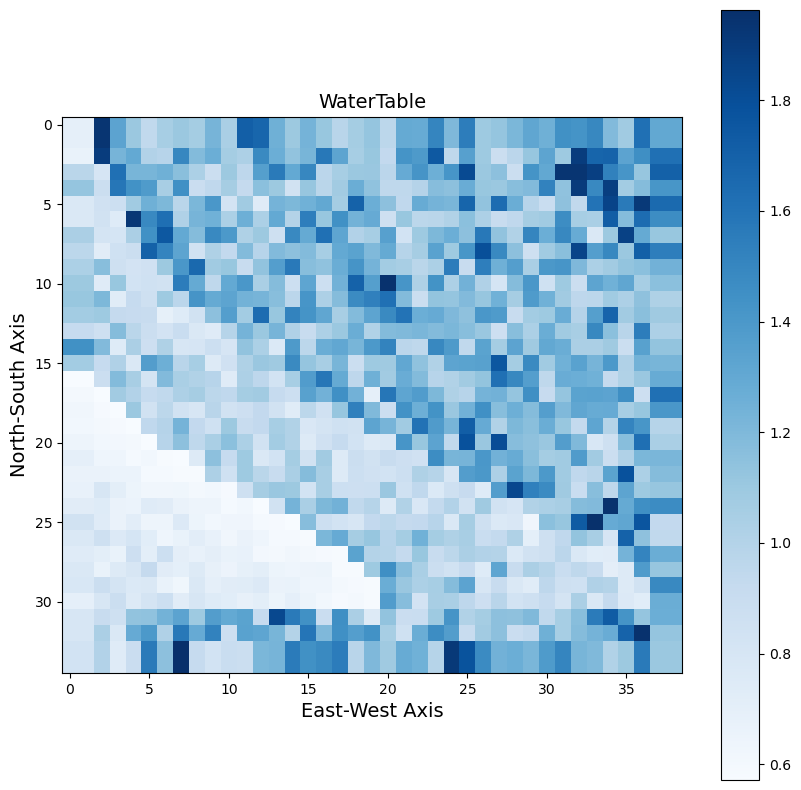

In [107]:
# plot the water level

def plot_water_table(timestep):
    #plot forest cover
    plt.figure(figsize=(10, 10))
    plt.imshow(W[:,:,timestep])

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('WaterTable', fontsize=14);
    plt.set_cmap("Blues")
    plt.colorbar()
    
    plt.show()
        
plot_water_table(7*24)